In [1]:
import scanpy as sc
import pandas as pd
import bbknn as bbknn
import numpy as np
import scipy.sparse as sp
import anndata

DATA_PATH_23 = 'data/GSE239626/MTX'
DATA_PATH_13 = 'GSE138266'
RANDOM_STATE = 42

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# load reference dataset
adata_ref_GSE239626 = sc.read_10x_mtx(
    DATA_PATH_23,
    var_names='gene_symbols',
    gex_only=True,
    cache=True)

# add cluster labels (assigned by clustering on protein data of reference dataset)
cluster_label_GSE239626 = pd.read_csv('results/cluster_labels.csv', index_col=0)
adata_ref_GSE239626.obs['cluster_label'] = cluster_label_GSE239626

# add cell type labels (on reference dataset)
cell_types_labels = pd.read_csv('results/GSE239626_cell_types.csv')
adata_ref_GSE239626.obs['cell_types_labels'] = cell_types_labels['CellTypist Low'].values # TODO: change

In [3]:
adata_ref_GSE239626

AnnData object with n_obs × n_vars = 72317 × 36601
    obs: 'cluster_label', 'cell_types_labels'
    var: 'gene_ids', 'feature_types'

In [4]:
# new dataset to be integrated with the reference dataset and the cell type labels
adata_GSE138266 = sc.read(DATA_PATH_13) # 5 patients and 5 control: PBMC + CSF cells

In [5]:
adata_GSE138266

AnnData object with n_obs × n_vars = 814177 × 33694
    obs: 'batch'
    var: 'gene_symbols', 'gene_ids'

In [6]:
adata_ref_GSE239626

AnnData object with n_obs × n_vars = 72317 × 36601
    obs: 'cluster_label', 'cell_types_labels'
    var: 'gene_ids', 'feature_types'

### Common Genes

In [7]:
adata_ref_GSE239626.var.head(3)

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression


In [8]:
adata_GSE138266.var.head(3)

,gene_symbols,gene_ids
0,ENSG00000243485,RP11-34P13.3
1,ENSG00000237613,FAM138A
2,ENSG00000186092,OR4F5


In [9]:
# list of genes that are in both datasets
common_genes = adata_ref_GSE239626.var['gene_ids'].isin(adata_GSE138266.var['gene_symbols'])
common_genes

MIR1302-2HG    True
FAM138A        True
OR4F5          True
AL627309.1     True
AL627309.3     True
               ... 
AC141272.1     True
AC023491.2     True
AC007325.1     True
AC007325.4     True
AC007325.2     True
Name: gene_ids, Length: 36601, dtype: bool

In [10]:
sum(common_genes)

32351

In [11]:
sum(adata_GSE138266.var['gene_symbols'].isin(adata_ref_GSE239626.var['gene_ids']))

32351

In [12]:
new_genes_ref = adata_GSE138266.var['gene_symbols'][~adata_GSE138266.var['gene_symbols'
    ].isin(adata_ref_GSE239626.var['gene_ids'])]
new_genes_ref

7        ENSG00000279928
8        ENSG00000279457
9        ENSG00000228463
10       ENSG00000236743
12       ENSG00000237094
              ...       
33404    ENSG00000249209
33429    ENSG00000280170
33473    ENSG00000237721
33493    ENSG00000225745
33560    ENSG00000232698
Name: gene_symbols, Length: 1343, dtype: object

In [13]:
new_genes_13 = adata_ref_GSE239626.var['gene_ids'][~adata_ref_GSE239626.var['gene_ids'
    ].isin(adata_GSE138266.var['gene_symbols'])]
new_genes_13

AL627309.5    ENSG00000241860
AP006222.2    ENSG00000286448
OR4F29        ENSG00000284733
OR4F16        ENSG00000284662
LINC01128     ENSG00000228794
                   ...       
AC010889.2    ENSG00000288049
AC009494.2    ENSG00000286247
AC010086.3    ENSG00000288057
AC024236.1    ENSG00000286187
PRYP3         ENSG00000169763
Name: gene_ids, Length: 4250, dtype: object

In [14]:
adata_ref_GSE239626

AnnData object with n_obs × n_vars = 72317 × 36601
    obs: 'cluster_label', 'cell_types_labels'
    var: 'gene_ids', 'feature_types'

In [15]:
# add new genes to the reference dataset
a = sc.AnnData(np.zeros((adata_ref_GSE239626.X.shape[0], len(new_genes_ref))))
a.var.index = new_genes_ref
a.obs.index = adata_ref_GSE239626.obs.index
a

AnnData object with n_obs × n_vars = 72317 × 1343

In [16]:
a.var.head(3)

""
gene_symbols
ENSG00000279928
ENSG00000279457
ENSG00000228463


In [17]:
adata_ref_GSE239626.var.index = adata_ref_GSE239626.var['gene_ids']
adata_ref_GSE239626.var.head(3)

,gene_ids,feature_types
gene_ids,,
ENSG00000243485,ENSG00000243485,Gene Expression
ENSG00000237613,ENSG00000237613,Gene Expression
ENSG00000186092,ENSG00000186092,Gene Expression


In [18]:
adata_ref_GSE239626_new = anndata.concat([adata_ref_GSE239626, a], axis=1)
adata_ref_GSE239626_new

AnnData object with n_obs × n_vars = 72317 × 37944

In [19]:
adata_ref_GSE239626_new.X

<72317x37944 sparse matrix of type '<class 'numpy.float64'>'
	with 96626578 stored elements in Compressed Sparse Row format>

In [20]:
1343 + 36601 # :) 37944

37944

In [21]:
a = sc.AnnData(sp.csr_matrix(np.zeros((adata_GSE138266.X.shape[0], len(new_genes_13)))))

a.var.index = new_genes_13
a.obs.index = adata_GSE138266.obs.index

adata_GSE138266.var.index = adata_GSE138266.var['gene_symbols']

In [22]:
adata_GSE138266_new = anndata.concat([adata_GSE138266, a], axis=1)
adata_GSE138266_new

AnnData object with n_obs × n_vars = 814177 × 37944

In [23]:
adata_GSE138266

AnnData object with n_obs × n_vars = 814177 × 33694
    obs: 'batch'
    var: 'gene_symbols', 'gene_ids'

In [24]:
adata_GSE138266_new.obs

""
AAACCTGAGTGGGCTA-1-GSM4104122-CSF
AAACCTGAGTGTTAGA-1-GSM4104122-CSF
AAACCTGGTCGCGTGT-1-GSM4104122-CSF
AAACCTGGTCTCCACT-1-GSM4104122-CSF
AAACCTGGTTTACTCT-1-GSM4104122-CSF
...
TTTGCGCGTGCAACGA-1-GSM4104143-PBMC
TTTGCGCTCCGTAGTA-1-GSM4104143-PBMC
TTTGGTTCACCACGTG-1-GSM4104143-PBMC
TTTGTCACACTGAAGG-1-GSM4104143-PBMC


### Preproc

In [25]:
sc.pp.normalize_total(adata_ref_GSE239626_new, target_sum=1e4)
sc.pp.log1p(adata_ref_GSE239626_new)

sc.pp.normalize_total(adata_GSE138266_new, target_sum=1e4)
sc.pp.log1p(adata_GSE138266_new)

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [26]:
sc.tl.pca(
    adata_ref_GSE239626_new,
    svd_solver='arpack',
    n_comps=30,
    random_state=RANDOM_STATE
    )

sc.pp.neighbors(
    adata_ref_GSE239626_new,
    n_neighbors=10,
    n_pcs=5,
    knn=True,
    metric='euclidean',
    random_state=RANDOM_STATE
    )

sc.tl.umap(
    adata_ref_GSE239626_new,
    n_components=2, # number of dimensions of the UMAP embedding
    method='umap',
    random_state=RANDOM_STATE,
    )

In [27]:
adata_ref_GSE239626_new.obs['cell_types_labels'] = adata_ref_GSE239626.obs['cell_types_labels'].values

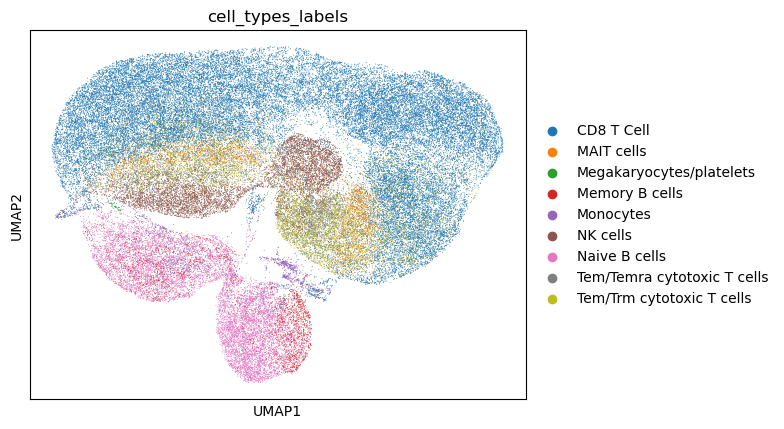

In [28]:
sc.pl.umap(adata_ref_GSE239626_new, color=['cell_types_labels'])

### Concat and Tranfer Labels

In [29]:
# reordering the adata_ref_GSE239626_new.var to match the adata_GSE138266_new.var
adata_GSE138266_new = adata_GSE138266_new[:, adata_ref_GSE239626_new.var.index]

In [30]:
adata_GSE138266_new.X

<814177x37944 sparse matrix of type '<class 'numpy.float64'>'
	with 78355676 stored elements in Compressed Sparse Row format>

In [ ]:
# integrate the new dataset with the reference dataset
sc.tl.ingest(adata_GSE138266_new, adata_ref_GSE239626_new, obs='cell_types_labels') # FIXME

In [ ]:
# concat the datasets
adata_transcriptomic = adata_ref_GSE239626_new.concatenate(adata_GSE138266_new,
    batch_categories=['reference_GSE239626', 'GSE138266'])

In [ ]:
adata_transcriptomic.obs.cell_types_labels = adata_transcriptomic.obs.cell_types_labels.astype('category')
adata_transcriptomic.obs.cell_types_labels.cat.reorder_categories(
    adata_ref_GSE239626.obs.cell_types_labels.cat.categories)  # fix category ordering

In [ ]:
sc.pl.umap(adata_transcriptomic, color=['batch', 'cell_types_labels'], ncols=1)

In [40]:
sc.tl.pca(adata_transcriptomic)

In [41]:
bbknn.bbknn(adata_transcriptomic, batch_key='batch')

In [ ]:
sc.tl.umap(adata_transcriptomic, random_state=RANDOM_STATE)

In [ ]:
sc.pl.umap(adata_transcriptomic, color=['batch', 'cell_types_labels'], ncols=1)

In [ ]:
sc.tl.embedding_density(adata_transcriptomic, groupby='batch')

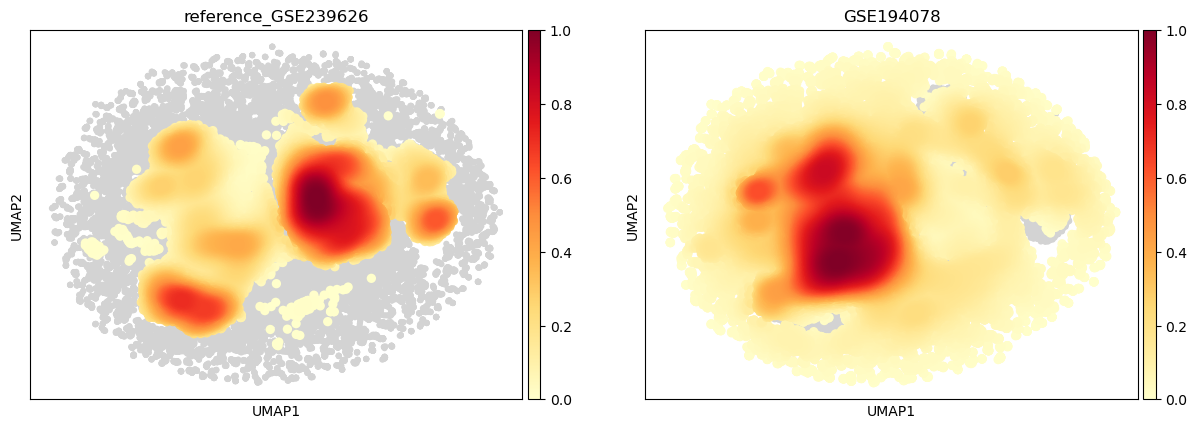

In [ ]:
sc.pl.embedding_density(adata_transcriptomic, groupby = 'batch')